a notebook for exploring the physics of loading single atoms in a dipole trap

In [19]:
import numpy as np
from numpy.random import rand, poisson
from scipy.stats import poisson as sp_poisson
import math
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# sample a Poisson distribution
def poisson_sample(size,domain,mean,showplot=False):
    """ Sample random speeds with a Maxwell-Boltzmann dist. 
        'size': sample size
        'domain': [v1,v2] the restricted domain of the pdf; e.g.
            a Guassian goes to zero well before inf so we could
            let the domain be a finite region
    """
    n = size 
    v1,v2 = domain

    poisson = lambda k: (np.exp(-mean)*mean**k)/math.factorial(k)

    fmax =  poisson(mean) # the maximum
    y_dist = np.empty(n)
    f_dist = np.empty(n) 
    v_dist = np.empty(n) # this is the distribution we want
    j = 0 # dist index
    while j < n:
        v = int((v2-v1)*rand()+0.5) # rand val on domain of f(x)
        f = poisson(v)
        y = rand()*fmax # rand val on range of f(x)
        if y <= f:
            y_dist[j]=y
            f_dist[j]=f
            v_dist[j]=v # x vals with approximate gaussian pdf
            j+=1

    # plot distribution as a check:
    if showplot is not False:
        plt.scatter(v_dist,y_dist,c='red',s=10)
        plt.scatter(v_dist,f_dist,c='blue',s=10)
        plt.show()

    return v_dist

## photocount distribution

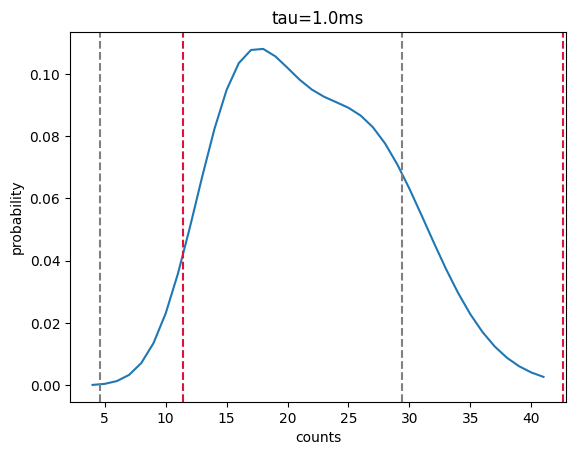

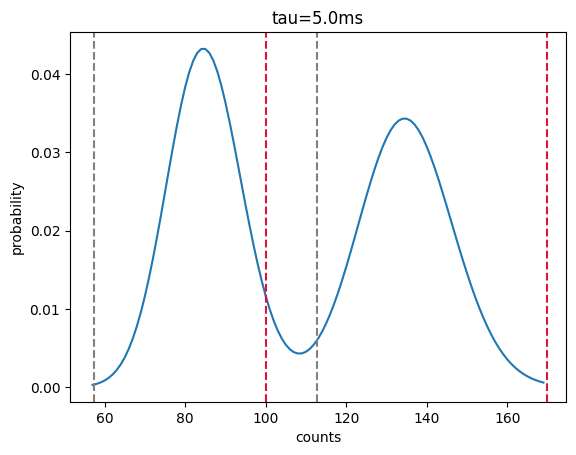

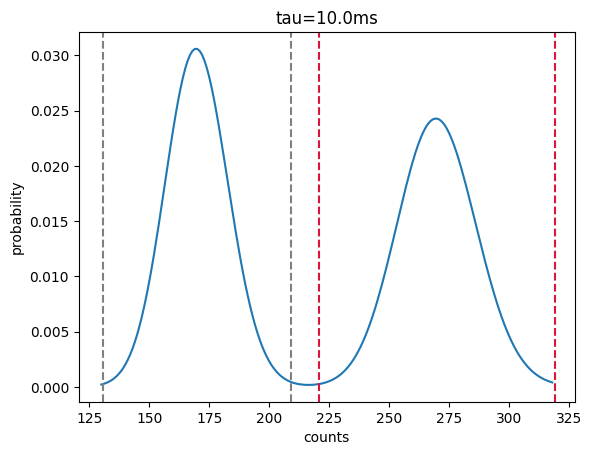

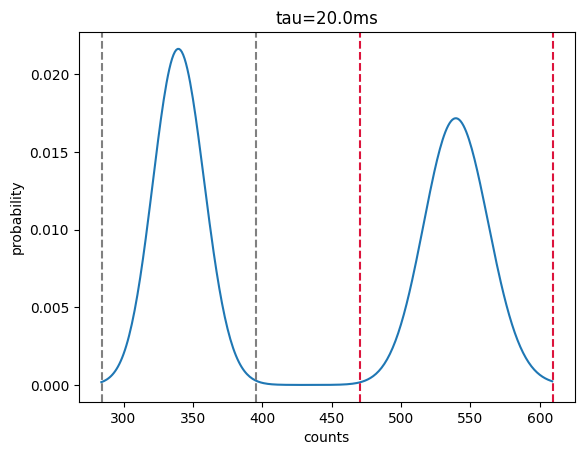

In [56]:
poisson = lambda k, mean: (np.exp(-mean)*mean**k)/math.factorial(k)
tau = 1e-3 # s
Rsig = 10000 # per s
Rbg = 17000 # per s

for tau in [1e-3,5e-3,10e-3,20e-3]:
    nsig = int(Rsig*tau)
    nbg = int(Rbg*tau)
    count_dist = lambda n: sp_poisson.pmf(n, nbg) + sp_poisson.pmf(n, nbg+nsig)
    counts = np.arange(nbg-3*np.sqrt(nbg), nsig+nbg+3*np.sqrt(nsig+nbg)).astype(int)
    plt.plot(counts, [count_dist(x) for x in counts])
    plt.axvline(nbg+3*np.sqrt(nbg),color='grey',linestyle='--')
    plt.axvline(nbg-3*np.sqrt(nbg),color='grey',linestyle='--',label='std(bg)')
    plt.axvline(nbg+nsig+3*np.sqrt(nbg+nsig),color='crimson',linestyle='--')
    plt.axvline(nbg+nsig-3*np.sqrt(nbg+nsig),color='crimson',linestyle='--',label='std(sig)')
    plt.title(f"tau={tau*1e3}ms")
    plt.xlabel("counts")
    plt.ylabel("probability")
    plt.show()

The probability that a number of photons measured to be m standard deviations above the mean background was due only to 
background (i.e. there is no atom) is 1 - the integral of the background from -inf up to m*sigma. I.e. P(background>+m\*sigma) = 1 - 0.5\*(1+Erf(m/2)). For m = 2 and 3, this is 0.023 and 0.001, respectively.

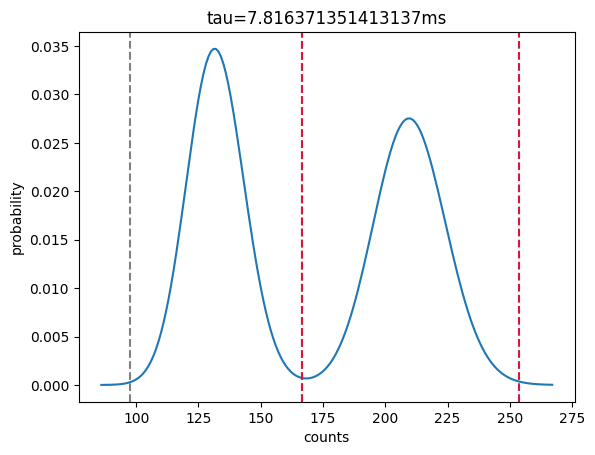

In [62]:
poisson = lambda k, mean: (np.exp(-mean)*mean**k)/math.factorial(k)
tau = 1e-3 # s
Rsig = 10000 # per s
Rbg = 17000 # per s

# suppose we want m*sigma between the signal and the cut-off
m = 3
tau = m**2*(2*Rbg+Rsig+2*np.sqrt((Rsig+Rbg)*Rbg))/Rsig**2

nsig = int(Rsig*tau)
nbg = int(Rbg*tau)
count_dist = lambda n: sp_poisson.pmf(n, nbg) + sp_poisson.pmf(n, nbg+nsig)
counts = np.arange(nbg-(m+1)*np.sqrt(nbg), nsig+nbg+(m+1)*np.sqrt(nsig+nbg)).astype(int)
plt.plot(counts, [count_dist(x) for x in counts])
plt.axvline(nbg+m*np.sqrt(nbg),color='grey',linestyle='--')
plt.axvline(nbg-m*np.sqrt(nbg),color='grey',linestyle='--',label=f'{m}std(bg)')
plt.axvline(nbg+nsig+m*np.sqrt(nbg+nsig),color='crimson',linestyle='--')
plt.axvline(nbg+nsig-m*np.sqrt(nbg+nsig),color='crimson',linestyle='--',label=f'{m}std(sig)')
plt.title(f"tau={tau*1e3}ms")
plt.xlabel("counts")
plt.ylabel("probability")
plt.show()

(225.0, 325.0)

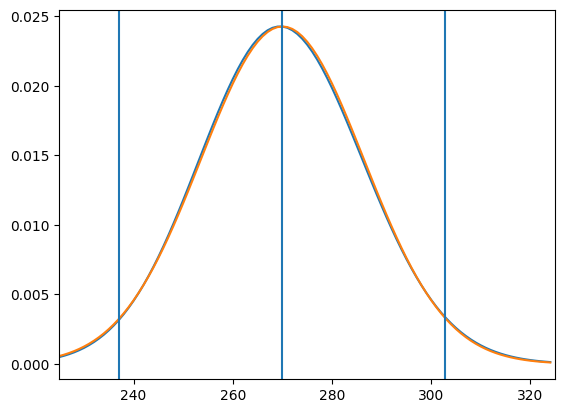

In [52]:
# def f(k, mean):
#     return np.exp(-mean)*(mean**k)/math.factorial(k)
npts = range(225,325)
nsig = 100
nbg = 170
fpts = [sp_poisson.pmf(n,nsig+nbg) for n in npts]
plt.plot(npts,fpts)
fpts = [np.exp(-(n-(nsig+nbg))**2/(2*(nsig+nbg)))/np.sqrt(2*np.pi*(nsig+nbg)) for n in npts]
plt.plot(npts,fpts)
plt.axvline(nsig+nbg)
plt.axvline(nsig+nbg-2*np.sqrt(nsig+nbg))
plt.axvline(nsig+nbg+2*np.sqrt(nsig+nbg))
plt.xlim((225,325))

## collisional blockade

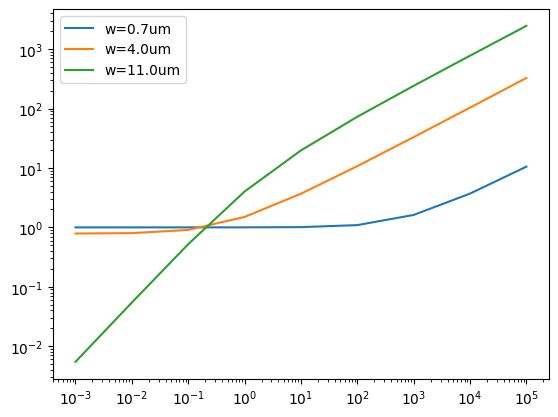

In [4]:
# collisional blockade
# not quite right. i solved the ode for steady-state atom number
# but this is evidently not the same as the mean atom number...
# Grangier paper does a Monte Carlo simulation

gamma = 0.2 # one-body loss

# assume beta = 1000 for a waist of 0.7 um
beta0 = 1000 # two-body losses with waist w0
w0 = 0.7
wlist = [w0, 4, 11]

R_list = np.array([10**i for i in range(-3,6)]) # rate of atoms falling into dipole trap

# R - gamma*N - beta*N*(N-1)
# R - gamma*N - beta*N**2 + beta*N
# R + (beta-gamma)*N - beta*N**2
# c + b*N + c*N**2
# a = -beta
# b = beta - gamma
# c = R
# N = (-b + np.sqrt(b**2 - 4*a*c))/(2*a)

N = lambda r, beta: (gamma - beta - np.sqrt((beta-gamma)**2 + 4*beta*r))/(-2*beta)

for w in wlist:
    B = beta0*(w0/w)**4 # two-body loss in the trap
    plt.plot(R_list,N(R_list,B), label=f'w={w:.1f}um')
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [5]:
dt = 0.1 # loading time
gamma = 0.2 # one-body loss

# assume beta = 1000 for a waist of 0.7 um
beta0 = 1000 # two-body losses with waist w0
R_list = np.array([10**i for i in range(-3,6)]) # rate of atoms falling into dipole trap

N_arr = np.zeros(len(R_list))
averages = 100 # how many times we try to load atoms for a given R
for i,R in enumerate(R_list):

    # generated number of loaded atoms for several trials
    N_mean = int(R*dt+0.5)
    N_loaded = poisson(N_mean, averages)
    
    # loop over each loading experiment
    for N in N_loaded:

        N_trapped = 0
        
        # loading time for each atom from a flat distribution
        t_loaded = sorted(rand(N)*dt)

        # loop over each time interval between loading events
        for n in range(N-1):
            N_trapped += 1 # atom loaded at t_loaded[n]
            dt_loaded = t_loaded[n+1] - t_loaded[n]

            p_onebody_loss = gamma*dt_loaded if gamma*dt_loaded < 1 else 1
            p_twobody_loss = beta*dt_loaded if beta*dt_loaded < 1 else 1
            if rand() < p_onebody_loss:
                N_trapped -= 1
            elif rand() < p_twobody_loss and N_trapped > 1:
                N_trapped -= 2
            if N_trapped == 0:
                break
        N_arr[i] += N_trapped
    N_arr[i] /= averages

NameError: name 'beta' is not defined

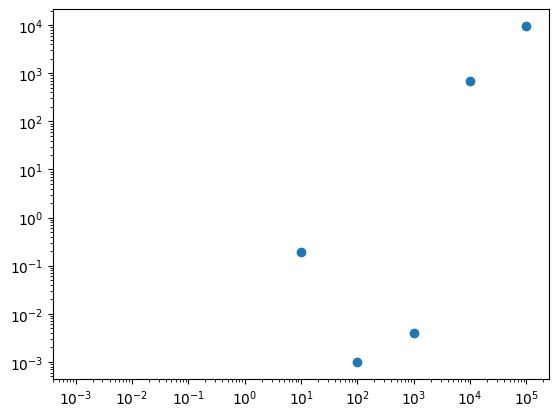

In [207]:
# for w in wlist:
plt.scatter(R_list,N_arr)#, label=f'w={w:.1f}um')
# plt.legend()
plt.xscale('log')
plt.yscale('log')

In [205]:
np.log10(N_arr)

C:\Users\prest\AppData\Local\Temp\ipykernel_18132\1494590239.py:1: RuntimeWarning: divide by zero encountered in log10
  np.log10(N_arr)


array([       -inf,        -inf,        -inf,        -inf, -0.52287875,
              -inf,        -inf,  3.17453951,  4.28288891])

## misc testing

In [184]:
# sample a Poisson distribution
def poisson_sample(size,domain,mean,showplot=False):
    """ Sample random speeds with a Maxwell-Boltzmann dist. 
        'size': sample size
        'domain': [v1,v2] the restricted domain of the pdf; e.g.
            a Guassian goes to zero well before inf so we could
            let the domain be a finite region
        'T': temperature
        'vectorial': 
            If False, only return a scalar. 
            Set to True to return velocity vectors with a 
            direction from a flat distribution. 
    """
    n = size 
    v1,v2 = domain

    def poisson(k): 
        return np.exp(-mean)*(mean**k)/math.factorial(k)

    fmax =  poisson(mean) # the maximum
    y_dist = np.empty(n)
    f_dist = np.empty(n) 
    v_dist = np.empty(n,dtype=int) # this is the distribution we want
    j = 0 # dist index
    while j < n:
        v = int((v2-v1)*rand()+0.5) # rand val on domain of f(x)
        f = poisson(v)
        y = rand()*fmax # rand val on range of f(x)
        if y <= f:
            y_dist[j]=y
            f_dist[j]=f
            v_dist[j]=v # x vals with approximate gaussian pdf
            j+=1

    # plot distribution as a check:
    if showplot is not False:
        plt.scatter(v_dist,y_dist,c='red',s=10)
        plt.scatter(v_dist,f_dist,c='blue',s=10)
        plt.show()

    return v_dist

In [185]:
mean = 700
k = mean
mean**k/math.factorial(k)*np.exp(-mean)

0.015076805912737029

9.85967654375977e-305

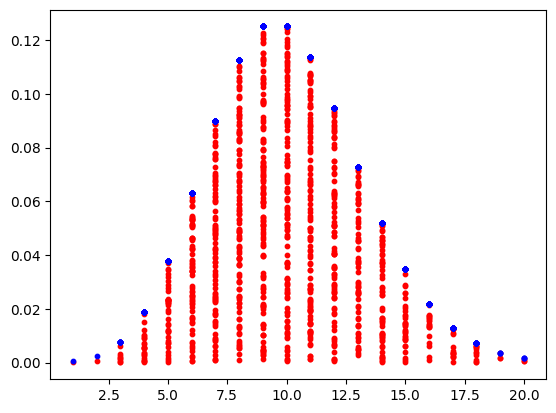

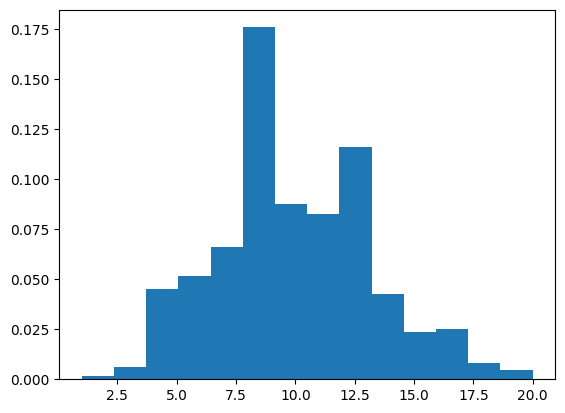

In [197]:
nmean = 10
sample = poisson_sample(1000,[0,30],nmean,showplot=True)
count, bins, ignored = plt.hist(sample, 14, density=True)
plt.show()

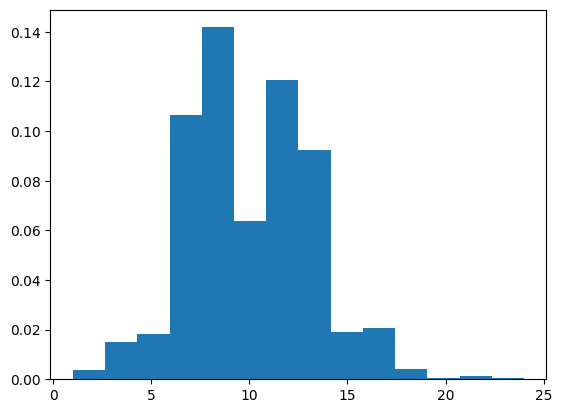

In [198]:
count, bins, ignored = plt.hist(poisson(10,1000), 14, density=True)
plt.show()

In [ ]:
plt.hist